In [ ]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xf images.tar

--2020-12-11 14:52:38--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  38.0MB/s    in 22s     

2020-12-11 14:53:00 (34.7 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-12-11 14:53:00--  http://files.heuritech.com/weights/alexnet_weights.h5
Resolving files.heuritech.com (files.heuritech.com)... 188.165.215.225
Connecting to files.heuritech.com (files.heuritech.com)|188.165.215.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243904576 (233M)
Saving to: ‘alexnet_weights.h5’

alexnet_weights.h5  100%[===================>] 232.61M  5.25MB/s    in 54s     

2020-12-11 14:53:55 (4.28 MB/s) - ‘alexnet_weights.h5’ saved

In [ ]:
from tensorflow import keras
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)
!pip3 install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds
import tarfile
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
%matplotlib inline
%load_ext tensorboard

     |████████████████████████████████| 2.3MB 5.5MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


# **Pre Process**

In [ ]:
address = "Images"
epochs = 50
input_size = (227, 227, 3)
random_state = 42
num_img = 20580
classes = 120
n_batch = 64
abspath = '/content/drive/My Drive/Colab Notebooks/HW4_AI/'

In [ ]:
# Make directory for saving models
directory = os.path.dirname(abspath + 'model/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
def preprocess(data, label):
    data_preprocessed = keras.applications.xception.preprocess_input(data)
    return data_preprocessed, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    address,
    validation_split=0.2,
    seed=123,
    shuffle=True,
    image_size=(input_size[0], input_size[1]),
    batch_size=n_batch,
    label_mode='categorical',
    subset='training') # set as training data

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    address, # same directory as training data
    image_size=(input_size[0], input_size[1]),
    batch_size=n_batch,
    seed=123,
    shuffle=True,
    validation_split=0.2,
    label_mode='categorical',
    subset='validation') # set as validation data
train_generator = train_generator.map(preprocess)
validation_generator = validation_generator.map(preprocess)
train_generator = train_generator.cache().shuffle(21000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


# **Proposed models**

Two models are implemented for breed classification. First one is AlexNet that is trained and implemented from scratch, and second one is Xception that is implemented and trained using pre_trained weights. Therefore accuracy of Xception is more than AlexNet by a large margin. 

# **AlexNet**

In [ ]:
from tensorflow.keras import layers
from keras.regularizers import l2
def model_AlexNet():
    np.random.seed(1000)
    
    model = Sequential()
    # 1 conv layer
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding="valid", activation="relu",
                     input_shape=input_size))
    # 1 max pool layer
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    # 2 conv layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation="relu"))
    # 2 max pool layer
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    # 3 conv layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"))
    # 4 conv layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"))
    # 5 conv layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"))
    # 3 max pool layer
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    # 1 dense layer
    model.add(Dense(4096, input_shape=input_size, activation="relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    # 2 dense layer
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    # 3 dense layer
    model.add(Dense(1000, activation="relu",kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    # output layer
    model.add(Dense(classes, activation="softmax"))

    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    loss = keras.losses.categorical_crossentropy
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='alexNet_model.png', show_shapes=True, show_layer_names=True)
    return model

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(abspath + '/model/alexNet_model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [ ]:
model = model_AlexNet()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_156 (Conv2D)          (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_465 (Bat (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_466 (Bat (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 9, 9, 384)       

In [ ]:
history_alexNet_model = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
    epochs = epochs)

Epoch 1/50
258/258 [==============================] - 13s 52ms/step - loss: 6.7156 - accuracy: 0.0225 - val_loss: 6.1344 - val_accuracy: 0.0294
Epoch 2/50
258/258 [==============================] - 12s 45ms/step - loss: 5.9219 - accuracy: 0.0275 - val_loss: 5.4371 - val_accuracy: 0.0437
Epoch 3/50
258/258 [==============================] - 12s 45ms/step - loss: 5.4017 - accuracy: 0.0361 - val_loss: 5.2086 - val_accuracy: 0.0442
Epoch 4/50
258/258 [==============================] - 12s 45ms/step - loss: 5.0600 - accuracy: 0.0471 - val_loss: 5.1151 - val_accuracy: 0.0556
Epoch 5/50
258/258 [==============================] - 12s 45ms/step - loss: 4.8527 - accuracy: 0.0562 - val_loss: 4.9553 - val_accuracy: 0.0620
Epoch 6/50
258/258 [==============================] - 12s 45ms/step - loss: 4.7022 - accuracy: 0.0609 - val_loss: 4.6116 - val_accuracy: 0.0736
Epoch 7/50
258/258 [==============================] - 10s 40ms/step - loss: 4.5550 - accuracy: 0.0723 - val_loss: 4.8101 - val_accuracy:

In [ ]:
import pandas as pd
def show_history(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return

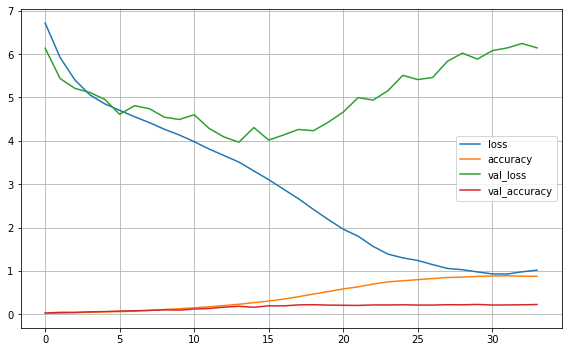

In [ ]:
show_history(history_alexNet_model)

# **Xception**

In [ ]:
epochs = 10
input_size = (299, 299, 3)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    address,
    validation_split=0.2,
    seed=123,
    shuffle=True,
    image_size=(input_size[0], input_size[1]),
    batch_size=n_batch,
    label_mode='categorical',
    subset='training') # set as training data

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    address, # same directory as training data
    image_size=(input_size[0], input_size[1]),
    batch_size=n_batch,
    seed=123,
    shuffle=True,
    validation_split=0.2,
    label_mode='categorical',
    subset='validation') # set as validation data
train_generator = train_generator.map(preprocess)
validation_generator = validation_generator.map(preprocess)
train_generator = train_generator.cache().shuffle(21000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.data_utils import get_file

def Xception(input_shape):
  WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
  img_input =  keras.Input(input_shape)
  # Block 1
  x = Conv2D(32,(3,3),strides=(2,2),use_bias=False)(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 2
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  # Block 2 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 3
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  # Block 3 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 4
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  # Block 5 - 12
  for i in range(8):
    residual = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])

  residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 13
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  # Block 13 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  # Block 14
  x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Block 14 part 2
  x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  model = Model(img_input, x, name='xception')
  weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels_notop.h5', WEIGHTS_PATH, cache_subdir='models')
  model.load_weights(weights_path)
  
  return model

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(abspath + '/model/xception_model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [ ]:
from keras.optimizers import SGD
def get_xception(ds_train,ds_val):
    img_size=(299,299)
    inputs=img_size + (3,)
    base_model = Xception(input_shape=inputs)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    predictions = Dense(120, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)


    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='xception_model.png', show_shapes=True, show_layer_names=True)
    for i, layer in enumerate(model.layers):
        if i < 81:
            layer.trainable = False
        else:
            layer.trainable = True

    history = model.fit(ds_train, batch_size=64, epochs=10, validation_data=ds_val,verbose=1,callbacks=[checkpoint_cb, early_stopping_cb])
    return history

In [ ]:
xception_model_history = get_xception(train_generator,validation_generator)

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 149, 149, 32) 864         input_30[0][0]                   
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 149, 149, 32) 128         conv2d_161[0][0]                 
__________________________________________________________________________________________________
activation_358 (Activation)     (None, 149, 149, 32) 0           batch_normalization_471[0][0]    
______________________________________________________________________________________

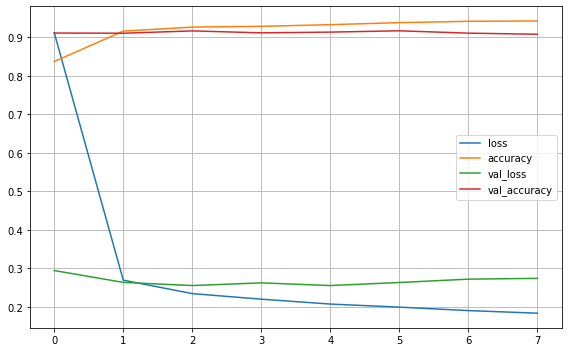

In [ ]:
show_history(xception_model_history)